**Try On Logistic Regresion 2**

In [10]:
#menghubungkan colab dengann gdrive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [15]:
#memanggil file dataset
path = "/content/gdrive/MyDrive/Praktikum_MachineLearning/Praktikum04"

In [16]:
#import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, RocCurveDisplay, ConfusionMatrixDisplay
)


In [17]:
#membaca file csv menggunakan pandas (pd)
df = pd.read_csv(path + "/data/stunting_wasting_dataset.csv")
df.head()

,Jenis Kelamin,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Stunting,Wasting
0,Laki-laki,19,91.6,13.3,Tall,Risk of Overweight
1,Laki-laki,20,77.7,8.5,Stunted,Underweight
2,Laki-laki,10,79.0,10.3,Normal,Risk of Overweight
3,Perempuan,2,50.3,8.3,Severely Stunted,Risk of Overweight
4,Perempuan,5,56.4,10.9,Severely Stunted,Risk of Overweight


In [18]:
#mencari tipe data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Jenis Kelamin      100000 non-null  object 
 1   Umur (bulan)       100000 non-null  int64  
 2   Tinggi Badan (cm)  100000 non-null  float64
 3   Berat Badan (kg)   100000 non-null  float64
 4   Stunting           100000 non-null  object 
 5   Wasting            100000 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 4.6+ MB


In [19]:
#cek missing value
df.isnull().sum()

,0
Jenis Kelamin,0
Umur (bulan),0
Tinggi Badan (cm),0
Berat Badan (kg),0
Stunting,0
Wasting,0


**Data Pre-Processing**

In [20]:
df.duplicated().sum()

np.int64(7308)

In [21]:
df = df.drop_duplicates()

In [22]:
df.duplicated().sum()

np.int64(0)

In [23]:
df['Stunting'].unique()

array(['Tall', 'Stunted', 'Normal', 'Severely Stunted'], dtype=object)

In [24]:
df['Jenis Kelamin'].unique()

array(['Laki-laki', 'Perempuan'], dtype=object)

In [26]:
#1. Mapping kolom Stunting -> biner
map_stunt = {'Stunted': 1, 'Severely Stunted': 1, 'Normal': 0, 'Tall':0}
df['Stunting_bin'] = df['Stunting'].map(map_stunt).astype('Int64')

#2. Mapping kolom jenis kelamin
#Laki-laki = 1, Perempuan = 0
df['JK_bin'] = (df['Jenis Kelamin'] == 'Laki-laki').astype(int)

print("Distribusi Stunting_bin:\n", df['Stunting_bin'].value_counts())
print("\nDistrubusi JK_bin:\n", df['JK_bin'].value_counts())

Distribusi Stunting_bin:
 Stunting_bin
0    72320
1    20372
Name: count, dtype: Int64

Distrubusi JK_bin:
 JK_bin
1    46353
0    46339
Name: count, dtype: int64


In [28]:
#mencari korelasi
corr_matrix = df.corr(numeric_only=True)
corr_matrix

,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Stunting_bin,JK_bin
Umur (bulan),1.000000,0.874162,0.659566,0.037173,0.000636
Tinggi Badan (cm),0.874162,1.000000,0.618453,-0.288216,0.070159
Berat Badan (kg),0.659566,0.618453,1.000000,0.020676,0.043446
Stunting_bin,0.037173,-0.288216,0.020676,1.000000,-0.005187
JK_bin,0.000636,0.070159,0.043446,-0.005187,1.000000


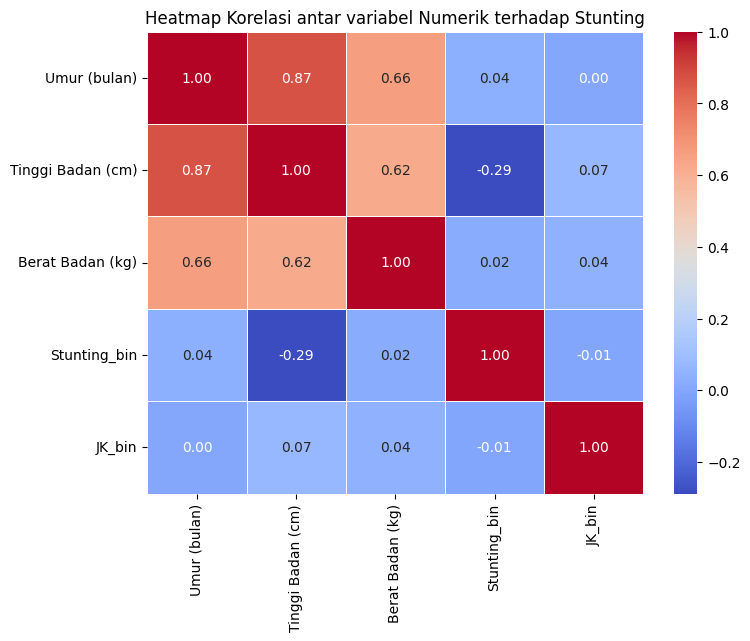

In [29]:
#visualisasi heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Heatmap Korelasi antar variabel Numerik terhadap Stunting', fontsize=12)
plt.show()

**Pembagian Dataset**

In [33]:
#fitur numerik dan gender
feature_num = ['Umur (bulan)', 'Tinggi Badan (cm)', 'Berat Badan (kg)']
feature_bin = ['JK_bin']

#gabungkan dan drop missing
use_cols = feature_num + feature_bin + ['Stunting_bin']
df_model = df[use_cols].dropna().copy()

X = df_model[feature_num + feature_bin]
y = df_model['Stunting_bin']

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (92692, 4)
y shape: (92692,)


In [36]:
X_train, x_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print("Data Training:", X_train.shape)
print("Data Testing:", x_test.shape)

Data Training: (74153, 4)
Data Testing: (18539, 4)


**Membangun Model**

In [37]:
#scale hanya fitur numerik, gender langsung passthrough
preprocess =  ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), feature_num),
        ('bin', 'passthrough', feature_bin)
    ],
    remainder='drop'
)

model = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    class_weight='balanced',
    random_state=42
)

clf = Pipeline([
    ('preprocess', preprocess),
    ('model', model)
])

#latih model
clf.fit(X_train, y_train)
print("👍Model Logistic Regression berhasil dilatih.")

👍Model Logistic Regression berhasil dilatih.


**Prediksi Model dan Evaluasi Model**

In [52]:
#prediksi model dan evaluasi model
#prediksi n pribabilitas
y_pred = clf.predict(x_test)
y_prob = clf.predict_proba(x_test)[:, 1]

#hitung metrik evaluasi
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print(f"Akurasi   : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision : {precision_score(y_test, y_pred, zero_division=0):.4f}")
print(f"Recall    : {recall_score(y_test, y_pred, zero_division=0):.4f}")
print(f"F1-Score  : {f1_score(y_test, y_pred, zero_division=0):.4f}")
print(f"ROC-AUC   : {roc_auc_score(y_test, y_prob):.4f}")

Akurasi   : 0.9020
Precision : 0.6996
Recall    : 0.9528
F1-Score  : 0.8068
ROC-AUC   : 0.9640


**Visualisasi Hasil Evaluasi**

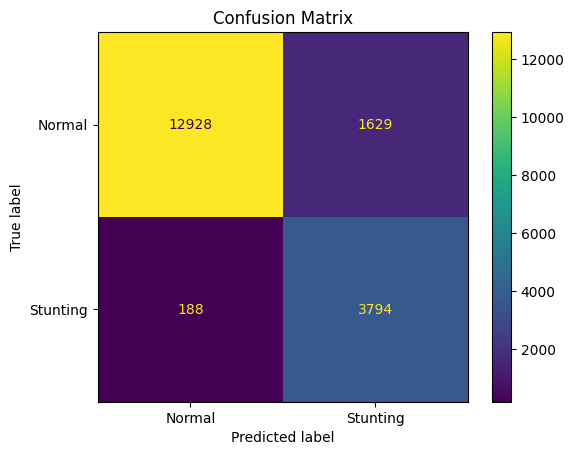

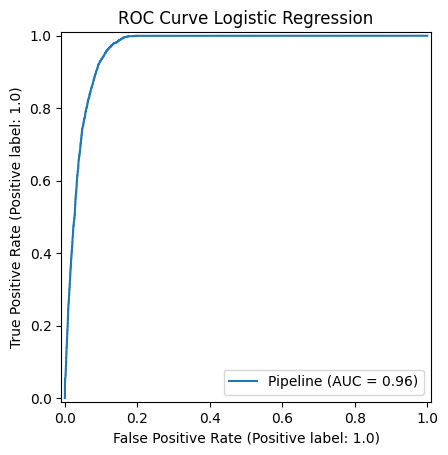

In [41]:
#confusion matrix
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, y_pred),
    display_labels=['Normal', 'Stunting']
).plot(values_format='d')

plt.title('Confusion Matrix')
plt.show()

#ROC curve
RocCurveDisplay.from_estimator(clf, x_test, y_test)
plt.title('ROC Curve Logistic Regression')
plt.show()

**Clasification** **Report**

In [42]:
from sklearn.metrics import classification_report

#classification report
print(classification_report(y_test, y_pred, target_names=['Tidak Stunting (0)', 'Stunting (1)']))

                    precision    recall  f1-score   support

Tidak Stunting (0)       0.99      0.89      0.93     14557
      Stunting (1)       0.70      0.95      0.81      3982

          accuracy                           0.90     18539
         macro avg       0.84      0.92      0.87     18539
      weighted avg       0.92      0.90      0.91     18539



**Cross Validation**

In [43]:
from sklearn.model_selection import cross_val_score

#cross validation
scores = cross_val_score(clf, X, y, cv=5)

#tampilkan hasil
print("Scor tiap fold:", scores)
print("Rata-rata akurasi:", np.mean(scores))
print("Standar deviasi:", np.std(scores))

Scor tiap fold: [0.9084093  0.90414801 0.90468227 0.90673212 0.9028482 ]
Rata-rata akurasi: 0.9053639814725255
Standar deviasi: 0.001970695381359219


**Interpretasi Model Logistic Regression**

In [47]:
#ambil nama fitur dan koefisien
feat_names = feature_num + feature_bin
coefs = clf.named_steps['model'].coef_[0]
odds = np.exp(coefs)

coef_df = pd.DataFrame({
    'Fitur': feat_names,
    'Koefisien (log-odds)': coefs,
    'Odds Ratio (e^coef)': odds
}).sort_values(by='Odds Ratio (e^coef)', ascending=False)

print(coef_df)

               Fitur  Koefisien (log-odds)  Odds Ratio (e^coef)
0       Umur (bulan)              8.681248          5891.394025
3             JK_bin              1.728174             5.630365
2   Berat Badan (kg)              0.647974             1.911665
1  Tinggi Badan (cm)            -10.748056             0.000021


**Prediksi Data Baru**

In [50]:
#contoh 2 anak
data_baru = pd.DataFrame({
    'Umur (bulan)': [24,10],
    'Tinggi Badan (cm)': [79.0, 72.5],
    'Berat Badan (kg)': [9.2, 7.8],
    'JK_bin': [1, 0]
})

pred = clf.predict(data_baru)
prob = clf.predict_proba(data_baru)[:, 1]

hasil = data_baru.copy()
hasil['Prob_Stunting'] = prob
hasil['Pred (0=Tidak, 1=Ya)'] = pred
display(hasil)

,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),JK_bin,Prob_Stunting,"Pred (0=Tidak, 1=Ya)"
0,24,79.0,9.2,1,0.998396,1.0
1,10,72.5,7.8,0,0.001795,0.0
